#### Before you run the notebook, make sure the homework files provided are in the same directory.
```
150180705/  
│   hw2.ipynb  
│
└───images/  
       aydemirakbas.png
       cat.jpg
       cat_landmarks.npy
       deniro.jpg
       gorilla.jpg
       gorilla_landmarks.npy
       kimbodnia.png
       panda.jpg
       panda_landmarks.npy
```

## PART 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dlib

import os
import copy
import cv2

In [2]:
class DownloadFailedError(Exception):    # Weird flex but ok!
    def __init__(self, message="curl failed to download the model. Please download manually!"):
        self.message = message
        super().__init__(self.message)

shape_predictor_model = "shape_predictor_68_face_landmarks.dat"
if not os.path.isfile(shape_predictor_model):
    try:
        !curl https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 --output "shape_predictor_68_face_landmarks.dat.bz2"
    except:
        raise DownloadFailedError
    !bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"
else:
    print("Model already exists. Skipping download.")

Model already exists. Skipping download.


In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_model)

In [4]:
def concat_images(images):
    assert len(images) == 6, "There must be six images in order to be displayed in a 2x3 matrix fashion"
    row1 = np.hstack((images[:3]))
    row2 = np.hstack((images[3:]))
    all_images = np.vstack((row1, row2))
    return all_images

In [5]:
images = {file.split(".")[0]:cv2.cvtColor(cv2.imread(os.path.join("images", file)), cv2.COLOR_BGR2RGB) for file in os.listdir("images") if file.endswith(".png") or file.endswith(".jpg")}
original_images = copy.deepcopy(images)
landmarks = {file.split("_")[0]:np.load(os.path.join("images", file)) for file in os.listdir("images") if file.endswith(".npy")}

In [6]:
def dlib_landmarks_to_numpy(points):
    points_np = np.asarray([[points.parts()[i].x, points.parts()[i].y] for i in range(68)])
    return points_np

In [7]:
# Add landmarks of famous people to the landmarks dict
for key in ("deniro", "aydemirakbas", "kimbodnia"):
    gray = cv2.cvtColor(images[key], cv2.COLOR_BGR2GRAY)
    rectangles = detector(gray)
    landmarks[key] = dlib_landmarks_to_numpy(predictor(gray, rectangles[0]))

In [8]:
for key in images:
    for x, y in landmarks[key]:
        cv2.circle(images[key], (x, y), 3, (0, 255, 0), -1)

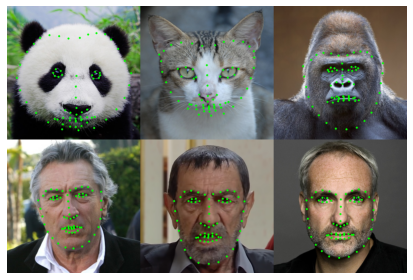

In [9]:
ordered_images = [images["panda"], images["cat"], images["gorilla"], images["deniro"], images["aydemirakbas"], images["kimbodnia"]]
all_images = concat_images(ordered_images)
plt.imshow(all_images)
plt.axis('off')
plt.tight_layout()

## PART 2

In [10]:
deniro_triangulation_image = original_images["deniro"].copy()
akbas_triangulation_image = original_images["aydemirakbas"].copy()

In [11]:
def get_subdiv(image, landmarks):
    subdiv = cv2.Subdiv2D((0, 0, image.shape[0], image.shape[1]))
    subdiv.insert(tuple(landmarks[i] for i in range(68)))
    # Corners
    subdiv.insert((0, 0))
    subdiv.insert((0, image.shape[1]-1))
    subdiv.insert((image.shape[0]-1, 0))
    subdiv.insert((image.shape[0]-1, image.shape[1]-1))
    # Centers of edges
    subdiv.insert((0, (image.shape[1]-1)//2))
    subdiv.insert(((image.shape[0]-1)//2, 0))
    subdiv.insert(((image.shape[0]-1)//2, image.shape[1]-1))
    subdiv.insert((image.shape[0]-1, (image.shape[1]-1)//2))
    return subdiv

In [138]:
def create_triangles(subdiv_src, subdiv_trg):
    src_triangles = subdiv_src.getTriangleList().astype("uint32")
    trg_triangles = np.empty((len(src_triangles), 6)).astype("uint32")
    for idx in range(len(src_triangles)):
        p1 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][0:2]))[0])[0]
        p2 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][2:4]))[0])[0]
        p3 = subdiv_trg.getVertex(subdiv_src.findNearest(tuple(src_triangles[idx][4:6]))[0])[0]
        points = [p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]]
        trg_triangles[idx:] = np.array(points)
    return trg_triangles

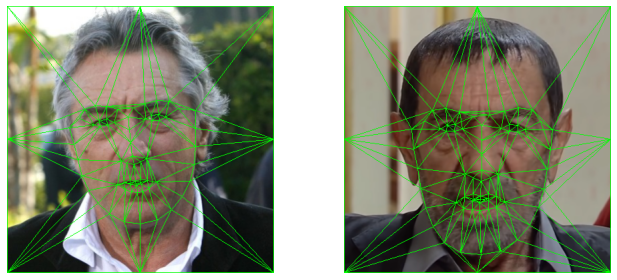

In [139]:
deniro_subdiv = get_subdiv(deniro_triangulation_image, landmarks["deniro"])
deniro_triangles = deniro_subdiv.getTriangleList().astype("uint32")
for triangle in deniro_triangles:
    t_points = [(triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])]
    cv2.line(deniro_triangulation_image, t_points[0], t_points[1], (0, 255, 0), 1)
    cv2.line(deniro_triangulation_image, t_points[1], t_points[2], (0, 255, 0), 1)
    cv2.line(deniro_triangulation_image, t_points[0], t_points[2], (0, 255, 0), 1)
    
akbas_subdiv = get_subdiv(akbas_triangulation_image, landmarks["aydemirakbas"])
akbas_triangles = create_triangles(deniro_subdiv, akbas_subdiv)
for triangle in akbas_triangles:
    t_points = [(triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])]
    cv2.line(akbas_triangulation_image, t_points[0], t_points[1], (0, 255, 0), 1)
    cv2.line(akbas_triangulation_image, t_points[1], t_points[2], (0, 255, 0), 1)
    cv2.line(akbas_triangulation_image, t_points[0], t_points[2], (0, 255, 0), 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(deniro_triangulation_image)
axes[1].imshow(akbas_triangulation_image)
for axis in axes:
    axis.set_axis_off()
fig.tight_layout()

## PART 3